# Troubleshooting Simulation 

In [21]:
import csv
import numpy as np
import datetime as dt
from shapely.geometry import Polygon
import pandas as pd
import matplotlib.pyplot as plt

from simulation import generate_catalog, simulate_aftershock_time
from inversion import round_half_up, polygon_surface, expected_aftershocks

from scipy.special import gammaincc, gammainccinv, gamma, gammainc
from scipy.stats import gaussian_kde

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

In [22]:
shape_coords = [list([a[1], a[0]]) for a in (np.load("california_shape.npy"))]
caliregion = Polygon(shape_coords)
area = polygon_surface(caliregion)
burn_start = dt.datetime(1871, 1, 1)
primary_start = dt.datetime(1871, 1, 1)
end = dt.datetime(2021, 1, 1)


mc=3.6
beta=2.4

params = {
    'log10_mu': -6.8,
    'log10_k0': -2.49,
    'a': 1.69,
    'log10_c': -2.95,
    'omega': -0.03,
    'log10_tau': 3.99,
    'log10_d': -0.35,
    'gamma': 1.22,
    'rho': 0.51,
    'M0': mc,
    'beta': beta
    }

/home/ss15859/anaconda3/envs/py-37-keras-21/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/ss15859/anaconda3/envs/py-37-keras-21/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [23]:
synthetic = generate_catalog(
        polygon=caliregion,
        timewindow_start=burn_start,
        timewindow_end=end,
        parameters=params,
        mc=mc,
        beta_main=beta,
        
    )


generating background events..
  number of background events needed: 8492
  generating 8492 to throw away those outside the polygon


/home/ss15859/anaconda3/envs/py-37-keras-21/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/ss15859/anaconda3/envs/py-37-keras-21/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/ss15859/anaconda3/envs/py-37-keras-21/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<a

  number of background events: 8492

  branching ratio: 0.8667056165577146
  expected total number of events (if time were infinite): 63708.610825878626


simulating aftershocks of generation 0 ..
  number of events with aftershocks: 4403
  number of generated aftershocks: 7108


simulating aftershocks of generation 1 ..
  number of events with aftershocks: 3798
  number of generated aftershocks: 6071


simulating aftershocks of generation 2 ..
  number of events with aftershocks: 3193
  number of generated aftershocks: 5307


simulating aftershocks of generation 3 ..
  number of events with aftershocks: 2837
  number of generated aftershocks: 4458


simulating aftershocks of generation 4 ..
  number of events with aftershocks: 2362
  number of generated aftershocks: 3742


simulating aftershocks of generation 5 ..
  number of events with aftershocks: 1970
  number of generated aftershocks: 3239


simulating aftershocks of generation 6 ..
  number of events with aftershocks: 1700
  num

In [24]:
synthetic = synthetic[["latitude", "longitude", "time", "magnitude"]]


In [25]:
synthetic

,latitude,longitude,time,magnitude
1,36,-122,1871-01-14 01:38:32.755265000,3.923400
2,36,-122,1871-01-16 12:03:39.613253000,4.604839
3,36,-122,1871-02-02 22:18:56.779805000,4.000704
4,36,-122,1871-02-03 12:14:37.710767000,3.929098
5,36,-122,1871-02-07 23:15:51.510108000,4.457550
...,...,...,...,...
58022,36,-122,2000-05-07 20:02:13.998604396,4.303463
58023,36,-122,2013-02-26 22:30:07.251042795,3.978866
58024,36,-122,2013-02-27 18:23:05.315577195,3.683023
58025,36,-122,1953-04-29 04:29:54.936328797,3.806231


In [26]:
synthetic = synthetic.sort_values('time')
synthetic

,latitude,longitude,time,magnitude
1,36,-122,1871-01-14 01:38:32.755265000,3.923400
2,36,-122,1871-01-16 12:03:39.613253000,4.604839
3,36,-122,1871-02-02 22:18:56.779805000,4.000704
4,36,-122,1871-02-03 12:14:37.710767000,3.929098
5,36,-122,1871-02-07 23:15:51.510108000,4.457550
...,...,...,...,...
15600,36,-122,2020-12-28 18:27:34.617379000,4.718601
15599,36,-122,2020-12-28 21:23:30.294076600,3.762061
21671,36,-122,2020-12-28 21:26:53.583772600,3.886331
26978,36,-122,2020-12-29 00:42:21.847055800,3.914071


In [27]:
dates = np.array(synthetic['time'])
delta_times = (dates-dates[0])
times=delta_times/ np.timedelta64(1, 'D')

In [28]:
mags = np.array(synthetic['magnitude'])

$$ g(t,x,y,m) = \frac{k_0 \cdot e^{a(m-m_c)} }{\frac{(t+c)^{1+\omega}}{e^{-t/\tau}} \cdot\left((x^2+y^2)+d \cdot e^{\gamma(m-m_c)}\right)^{1+\rho} }$$

To simply this to only temporal, we can take the same parameter values and just ensure that $x$ and $y$ are always zero. The triggering function then becomes:
$$ g(t,m) = \frac{k_0 \cdot e^{a(m-m_c)} }{\frac{(t+c)^{1+\omega}}{e^{-t/\tau}} \cdot\left(d \cdot e^{\gamma(m-m_c)}\right)^{1+\rho} }$$

The intensity at time $t$ is:
\begin{align*} \lambda(t) &= \mu + \sum_{t_i<t} g(t-t_i,m_i) \\
&= \mu + \sum_{t_i<t} h(t-t_i) k(m_i)
\end{align*}

Where,
$$h(t) = \frac{e^{-t/\tau}}{(t+c)^{1+\omega}}$$

$$k(m) = \frac{k_0 \cdot e^{a(m-m_c)}}{\left(d \cdot e^{\gamma(m-m_c)}\right)^{1+\rho} } $$

In [29]:
tau=10**float(params["log10_tau"])
c= 10**float(params["log10_c"])
w = float(params["omega"])
k0 = 10**float(params["log10_k0"])
alpha = float(params["a"])
M0 = float(params["M0"])
d = 10**float(params["log10_d"])
rho = float(params["rho"])
ground = 10**float(params["log10_mu"])
gama = float(params["gamma"])
beta = float(params["beta"])


# def h(t):
#     return np.exp(-t/tau)/((t+c)**(1+w))

# def k(m):
#     return k0 * np.exp(alpha * (m - M0))/((d*np.exp(gamma*(m-M0)))**(1+rho))


scale = 1/(gamma(-w)*np.power(tau,-1*w))

def upper_gamma_ext(a, x):
    if a > 0:
        return gammaincc(a, x) * gamma(a)
    elif a == 0:
        return exp1(x)
    else:
        return (upper_gamma_ext(a + 1, x) - np.power(x, a)*np.exp(-x)) / a

def h(t):
    return scale*np.exp(-t/tau)/(np.power(t+c,(1+w)))

# def k(m):
#     return k0*np.exp(alpha*(m-M0))/(np.power(d*np.exp(gama*(m-M0)),(1+rho)))

def k(m):
    
    number_factor = k0 * np.exp(alpha * (m - M0))
    area_factor = np.pi * np.power(
        d * np.exp(gama * (m - M0)),
        -1 * rho
    ) / rho

    time_factor = np.exp(c/tau) * np.power(tau, -w) 
    time_fraction = upper_gamma_ext(-w, c/tau)
    
    
    return number_factor*area_factor*time_factor*time_fraction

# def H(t):
#     return (1/gamma(-w))*gammainc(-w,t/tau)

def H(t):
    return 1 - gammaincc(-w,(t+c)/tau)/gammaincc(-w,c/tau)


In [ ]:
upper_gamma_ext(-w, c/tau)

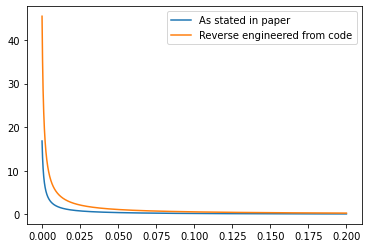

In [34]:
# t = simulate_aftershock_time(params["log10_c"], w, params["log10_tau"], size=100000)
def f(x):
    return np.exp(-(x+c)/tau)/(gammaincc(-w,c/tau)*tau*np.power(((x+c)/tau),1+w)*gamma(-w))



# density = gaussian_kde(t)
x=np.linspace(0,0.2,100000)
# plt.plot(x,density(x),label='simulated density')
# # plt.hist(t,density=True)
plt.plot(x,h(x),label='As stated in paper')
plt.plot(x,f(x),label='Reverse engineered from code')
plt.legend()

In [ ]:
T_train[-30:]

In [ ]:
(T_test[-1]-T_test[time_step+1])

In [ ]:
((T_test[-1])-T_test[time_step+1:])[-30:]

In [13]:
# def marked_ETAS_intensity(Tdat,Mdat):
    
#     lam = np.zeros_like(Tdat)
#     lam[0] = ground*area
#     for i in range(len(lam)):
    
#         cumulative = 0
#         for j in range(1,i):
#             cumulative += k(Mdat[j])*h((Tdat[i]-Tdat[j]))

    
#         lam[i] = ground*area + cumulative
    
#     return lam 

theta_without_mu = params["log10_k0"], params["a"], params["log10_c"], params["omega"], \
                       params["log10_tau"], params["log10_d"], params["gamma"], params["rho"]

def marked_ETAS_intensity(Tdat,Mdat):
    
    lam = np.zeros_like(Tdat)
    lam[0] = ground*area
    for i in range(len(lam)):
    
        cumulative = 0
        for j in range(1,i):
            cumulative += k(Mdat[j])*f(Tdat[i]-Tdat[j])

    
        lam[i] = ground*area + cumulative
    
    return lam 


def marked_likelihood(Tdat,Mdat,maxTime):
    temp = np.log(ground*area)
    for i in range(1,len(Tdat)):
        
        temp += np.log(ground*area + sum(k(Mdat[:(i )]) * f(Tdat[i] - Tdat[:(i)]))+1e-7)
    
    temp = temp - ground*maxTime*area
    temp = temp - sum(k(Mdat) * H(maxTime - Tdat))
    
    return temp

In [ ]:
x = np.linspace(8,10,1000)
plt.plot(x,k(x),alpha=0.8,label='mine')
plt.plot(x,expected_aftershocks(x,params=[theta_without_mu, M0],no_start=True,no_end=True),alpha=0.5,label='hers')
plt.legend()

In [14]:
lamtimes=times[:4000]
lammags=mags[:4000]

In [15]:
lam = marked_ETAS_intensity(lamtimes,lammags)

In [16]:
## hyper parameters
time_step = 20 # truncation depth of RNN 
size_rnn = 64 # the number of units in the RNN
size_nn = 64 # the nubmer of units in each hidden layer in the cumulative hazard function network
size_layer_chfn = 2 # the number of the hidden layers in the cumulative hazard function network
size_layer_cmfn = 2

T_train=times
M_train=mags

## mean and std of the log of the inter-event interval, which will be used for the data standardization
mu = np.log(np.ediff1d(T_train)).mean()
sigma = np.log(np.ediff1d(T_train)).std()

mu1 = np.log(M_train).mean()
sigma1 = np.log(M_train).std()

## kernel initializer for positive weights
def abs_glorot_uniform(shape, dtype=None, partition_info=None): 
    return K.abs(keras.initializers.glorot_uniform(seed=None)(shape,dtype=dtype))

## Inputs 

event_history = layers.Input(shape=(time_step,2))
elapsed_time = layers.Input(shape=(1,)) # input to cumulative hazard function network (the elapsed time from the most recent event)
current_mag = layers.Input(shape=(1,)) 


## log-transformation and standardization
# event_history_nmlz = layers.Lambda(lambda x: (K.log(x)-mu)/sigma )(event_history) ## probs have to do matrix equivalent for this
elapsed_time_nmlz = layers.Lambda(lambda x: (K.log(x)-mu)/sigma )(elapsed_time) 

numpyA = np.array([[1/sigma,0],[0,1/sigma1]])

def multA(x,A):
    A = K.constant(numpyA)

    return K.dot(x,A)

event_history_nmlz = layers.Lambda(lambda x: multA(K.log(x)-[mu,mu1],numpyA))(event_history)
current_mag_nmlz = layers.Lambda(lambda x: (K.log(x)-mu1)/sigma1 )(current_mag)

## RNN
output_rnn = layers.SimpleRNN(size_rnn,input_shape=(time_step,2),activation='tanh')(event_history_nmlz)

## the first hidden layer in the cummulative hazard function network
hidden_tau = layers.Dense(size_nn,kernel_initializer=abs_glorot_uniform,kernel_constraint=keras.constraints.NonNeg(),use_bias=False)(elapsed_time_nmlz) # elapsed time -> the 1st hidden layer, positive weights
hidden_rnn = layers.Dense(size_nn)(output_rnn) # rnn output -> the 1st hidden layer
hidden = layers.Lambda(lambda inputs: K.tanh(inputs[0]+inputs[1]) )([hidden_tau,hidden_rnn])

## the second and higher hidden layers
for i in range(size_layer_chfn-1):
    hidden = layers.Dense(size_nn,activation='tanh',kernel_initializer=abs_glorot_uniform,kernel_constraint=keras.constraints.NonNeg())(hidden) # positive weights

## the first hidden layer in the cummulative hazard function network
hidden_mu = layers.Dense(size_nn,kernel_initializer=abs_glorot_uniform,kernel_constraint=keras.constraints.NonNeg(),use_bias=False)(current_mag_nmlz) # elapsed time -> the 1st hidden layer, positive weights
hidden_rnn_mag = layers.Dense(size_nn)(output_rnn) # rnn output -> the 1st hidden layer
hidden_mag = layers.Lambda(lambda inputs: K.tanh(inputs[0]+inputs[1]) )([hidden_mu,hidden_rnn_mag,hidden_tau])

## the second and higher hidden layers
for i in range(size_layer_cmfn-1):
    hidden_mag = layers.Dense(size_nn,activation='tanh',kernel_initializer=abs_glorot_uniform,kernel_constraint=keras.constraints.NonNeg())(hidden_mag) # positive weights
    
    
    
## Outputs
Int_l = layers.Dense(1, activation='softplus',kernel_initializer=abs_glorot_uniform, kernel_constraint=keras.constraints.NonNeg() )(hidden) # cumulative hazard function, positive weights
l = layers.Lambda( lambda inputs: K.gradients(inputs[0],inputs[1])[0] )([Int_l,elapsed_time]) # hazard function
Int_l_mag = layers.Dense(1, activation='softplus',kernel_initializer=abs_glorot_uniform, kernel_constraint=keras.constraints.NonNeg() )(hidden_mag) # cumulative hazard function, positive weights
l_mag= layers.Lambda( lambda inputs: K.gradients(inputs[0],inputs[1])[0] )([Int_l_mag,current_mag]) # hazard function

## define model
model = Model(inputs=[event_history,elapsed_time,current_mag],outputs=[l,Int_l,l_mag,Int_l_mag])
model.add_loss( -K.mean( K.log( 1e-10 + l )+ K.log(1e-10 + l_mag ) - Int_l ) ) # set loss function to be the negative log-likelihood function

In [17]:
## format the input data
dM_train = np.delete(mags,0)

dT_train = np.ediff1d(times) # transform a series of timestamps to a series of interevent intervals: T_train -> dT_train
n = dT_train.shape[0]
n2 = dM_train.shape[0]
input_RNN_times = np.array( [ dT_train[i:i+time_step] for i in range(n-time_step) ]).reshape(n-time_step,time_step,1)
input_RNN_mags = np.array( [ dM_train[i:i+time_step] for i in range(n2-time_step) ]).reshape(n2-time_step,time_step,1)
input_RNN = np.concatenate((input_RNN_times,input_RNN_mags),axis=2)
input_CHFN = dT_train[-n+time_step:].reshape(n-time_step,1)
input_CMFN =dM_train[-n+time_step:].reshape(n-time_step,1)


## training 
model.compile(keras.optimizers.Adam(lr=0.001))
model.fit([input_RNN,input_CHFN,input_CMFN],epochs=30,batch_size=256,validation_split=0.2) # In our study, we have set epochs = 100 and employed early stopping. Please see code.ipynb for more details.

Train on 8844 samples, validate on 2211 samples
Epoch 1/30
8844/8844 [==============================] - 1s 158us/sample - loss: 2.2036 - val_loss: 0.2092
Epoch 2/30
8844/8844 [==============================] - 0s 33us/sample - loss: 0.1312 - val_loss: -0.4605
Epoch 3/30
8844/8844 [==============================] - 0s 33us/sample - loss: -0.2294 - val_loss: -0.6686
Epoch 4/30
8844/8844 [==============================] - 0s 33us/sample - loss: -0.3976 - val_loss: -0.7984
Epoch 5/30
8844/8844 [==============================] - 0s 37us/sample - loss: -0.5334 - val_loss: -0.9459
Epoch 6/30
8844/8844 [==============================] - 0s 38us/sample - loss: -0.6591 - val_loss: -1.0478
Epoch 7/30
8844/8844 [==============================] - 0s 39us/sample - loss: -0.7657 - val_loss: -1.1359
Epoch 8/30
8844/8844 [==============================] - 0s 39us/sample - loss: -0.8541 - val_loss: -1.2240
Epoch 9/30
8844/8844 [==============================] - 0s 37us/sample - loss: -0.9257 - val_loss:

In [18]:
[l_test,Int_l_test,l_mag_test,Int_mag_test] = model.predict([input_RNN,input_CHFN,input_CMFN],batch_size=input_RNN.shape[0])
LL = np.log(l_test+1e-10) - Int_l_test  # log-liklihood
print("Mean negative log-likelihood per event: ",-LL.mean())

Mean negative log-likelihood per event:  1.8188766


In [19]:
T_test=T_train
M_test=M_train
TLL = -marked_likelihood(T_test[time_step+1:],M_test[time_step+1:],(T_test[-1]))/len(T_test[time_step+1:])
print("True mean negative log-likelihood per event: ",TLL)

True mean negative log-likelihood per event:  1.797813494946289


In [20]:
T_train

array([0.00000000e+00, 6.89294115e-01, 4.70042355e+01, ...,
       5.47420837e+04, 5.47464395e+04, 5.47531939e+04])

In [ ]:
timesplot=times[time_step+1:]
lam=lam[time_step+1:]

In [ ]:
i = 390
index=range(i,i+20)
plt.plot(timesplot[index],l_test[index],label='predicted')
plt.plot(timesplot[index],lam[index],label='true')
plt.legend()

In [ ]:
i = 1076
index=range(i,i+13)
plt.plot(timesplot[index],l_test[index],label='predicted')
plt.plot(timesplot[index],lam[index],label='true')
plt.legend()

In [ ]:
rho

In [ ]:
plt.plot(timesplot[:3979],abs(l_test[:3979,0]-lam)/(lam))

In [ ]:
(l_test[:,0]/lam).mean()

In [ ]:
lammags.argmax()

In [ ]:
lammags.max()

In [ ]:
binwidth=0.5
plt.hist(dT_train,bins=np.arange(min(dT_train), max(dT_train) + binwidth, binwidth),density=True)